
# Project: European Soccer Data Analysis
##### Comparing match results & goals scored by league

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#resources">Resources</a></li>
</ul>

<a id='intro'></a>
## Introduction

_____

In this project, I plan to compare match results across the various European soccer leagues. To complete this project, I will be using the [European Soccer Dataset](https://www.kaggle.com/hugomathien/soccer#database.sqlite), which can be found on Kaggle. This database contains records of European soccer matches that have taken place from 2008 to 2016. This dataset provides good practice with querying a SQLite database and joining tables/dataframes.

The first part of my project will explore the win rates of the home and away teams in each league. For each match, there can only be three outcomes: the home team wins, the away team wins or the match is a draw (tie). Although the match result is not explicitly stated in the database, it can be determined by comparing the home team goals scored and away team goals scored in a given match. 

Although it's not officially measured, athletes, commentators and fans constantly mentioned "home field advantage" in connection to match result. Although this exploration will not dive into the causes of home field advtange, I expect there to be a higher rate of home wins against both away wins and draws. Perhaps the breakdown of match result by league will allow us to determine which league matches are most likely to end in a home team win.

The second part of this project will then compare goals scored per match in each league. If the assumption that the home team most often wins a given match proves to be true, then we can hypothesize that the average number of goals scored by the home team in a match will be greater than the average number of goals scored by the away team. After this analysis, I should be able to determine which league matches are most likely to have the most goals scored in a game. 

Let's get started!
__________________

In [125]:
# Import packages for project
import pandas as pd
import sqlite3
import numpy as np

<a id='wrangling'></a>
## Data Wrangling
___
In this section, I will load each table from the SQLite database, and inspect the data for cleanliness. At this point, I will make adjustments for any missing values, unnecessary columns, etc. Taking time to understand the dataset will help me with upcoming analysis.

### General Properties

In [126]:
# read sqlite query results into a pandas DataFrame

con = sqlite3.connect("./database.sqlite")

df_team = pd.read_sql_query("SELECT team_api_id, team_long_name from Team", con)
df_match = pd.read_sql_query("SELECT match_api_id, date, league_id, stage, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal from Match", con)
df_league = pd.read_sql_query("SELECT id, name from League", con)

con.close()

In [127]:
# Verify Team table has been saved as df_team dataframe

df_team.head(1)

,team_api_id,team_long_name
0,9987,KRC Genk


In [128]:
# Verify Match table has been saved as df_match dataframe

df_match.head(1)

,match_api_id,date,league_id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,492473,2008-08-17 00:00:00,1,1,9987,9993,1,1


In [129]:
# Verify League table has been saved as df_league dataframe

df_league.head(1)

,id,name
0,1,Belgium Jupiler League


In [130]:
# check df_team for null values

df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
team_api_id       299 non-null int64
team_long_name    299 non-null object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [131]:
# check df_match for null values

df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 8 columns):
match_api_id        25979 non-null int64
date                25979 non-null object
league_id           25979 non-null int64
stage               25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(7), object(1)
memory usage: 1.6+ MB


In [132]:
# check df_league for null values

df_league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


### Total Game in Dataset: 25,979

##### No null values present in this dataset

After displaying the info above, it is apparent the same number of data points are present in each column of each table. This means that there are no missing values in any of the tables. Woohoo! Had there been any null values, I would have additional data cleaning at this point. 

In [133]:
df_match['home_team_goal'].describe()

count    25979.000000
mean         1.544594
std          1.297158
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: home_team_goal, dtype: float64

In [134]:
df_match['away_team_goal'].describe()

count    25979.000000
mean         1.160938
std          1.142110
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: away_team_goal, dtype: float64

#### *Further investigation of home & away team goals*

The outputs of means and percentiles gives a good outline of what the data will demonstrate. The mean of home team goals per game is nearly 0.4 goals greater than the away team goals per game. It is also interesting the 50th and 75th percentile outcomes are identical for both home and away goals scored per game. However, in the 25th percentile, there is one goal per game for the home team and zero goals per game for the away team. In the scenario where both teams under-perform, the home team has an advantage to win the game.  

### Data Cleaning: Renaming Columns In Preparation of Merging Dataframes

In [135]:
# Rename columns in df_team and save titles to new home team dataframe

df_home_team = df_team.rename(columns={"team_api_id": "home_team_api_id", "team_long_name": "home_team_name"})

df_home_team.head(1)

,home_team_api_id,home_team_name
0,9987,KRC Genk


In [136]:
# Rename columns in df_team and save titles to new away team dataframe

df_away_team = df_team.rename(columns={"team_api_id": "away_team_api_id", "team_long_name": "away_team_name"})

df_away_team.head(1)

,away_team_api_id,away_team_name
0,9987,KRC Genk


In [137]:
# Merge df_home_team with df_match

df_match_combined = pd.merge(df_match, df_home_team, left_on='home_team_api_id', right_on='home_team_api_id')

df_match_combined.head(1)

,match_api_id,date,league_id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name
0,492473,2008-08-17 00:00:00,1,1,9987,9993,1,1,KRC Genk


In [138]:
# Merge df_away_team with previously created df_match_combined dataframe

df_match_combined = pd.merge(df_match_combined, df_away_team, left_on='away_team_api_id', right_on='away_team_api_id')

df_match_combined.head(1)

,match_api_id,date,league_id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name,away_team_name
0,492473,2008-08-17 00:00:00,1,1,9987,9993,1,1,KRC Genk,Beerschot AC


In [139]:
# Rename columns in df_league and save as df_league_revised

df_league_revised = df_league.rename(columns={"id": "league_id", "name": "league_name"})

df_league_revised.head(1)

,league_id,league_name
0,1,Belgium Jupiler League


In [140]:
# Merge df_league_revised with df_match_combined

df_match_combined = pd.merge(df_match_combined, df_league_revised, left_on='league_id', right_on='league_id')

df_match_combined.head(5)

,match_api_id,date,league_id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name,away_team_name,league_name
0,492473,2008-08-17 00:00:00,1,1,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium Jupiler League
1,665353,2009-08-30 00:00:00,1,5,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium Jupiler League
2,838476,2010-08-01 00:00:00,1,1,9987,9993,2,1,KRC Genk,Beerschot AC,Belgium Jupiler League
3,1032694,2011-07-30 00:00:00,1,1,9987,9993,3,1,KRC Genk,Beerschot AC,Belgium Jupiler League
4,1224064,2012-10-20 00:00:00,1,11,9987,9993,3,0,KRC Genk,Beerschot AC,Belgium Jupiler League


### *Cleaned Data Initial Exploration*
___

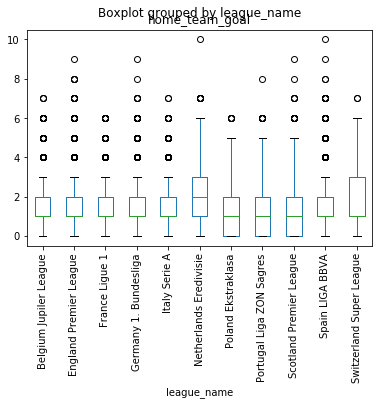

In [141]:
plt = df_match_combined.boxplot(by ='league_name', column =['home_team_goal'], grid = False, rot=90)

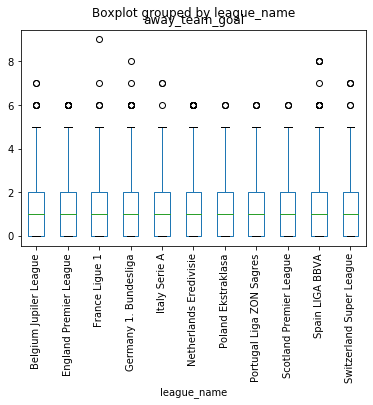

In [142]:
plt = df_match_combined.boxplot(by ='league_name', column =['away_team_goal'], grid = False, rot=90)

##### Outliers within the dataset

Relying on ```.describe()``` to summarize the dataset, does not provide enough context. The boxplots are a good demonstration of outliers while exploring goals scored by home and away teams.

<a id='eda'></a>
## Exploratory Data Analysis

### Initial Question: Across European soccer leagues, is the most frequent match result a home team win?

In [143]:
# Create function to determine winning team in each row of df_match_combnined

def determineWinningTeam(row):

    if row['home_team_goal'] == row['away_team_goal']:

        result = 'draw'

    elif row['home_team_goal'] > row['away_team_goal']:

        result = 'home'

    else:

        result = 'away'

    return result

In [144]:
# Run function and set match_result for each match

df_match_combined['match_result'] = df_match_combined.apply(determineWinningTeam, axis=1)

# Verify match_result column displays

df_match_combined.head(5)

,match_api_id,date,league_id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name,away_team_name,league_name,match_result
0,492473,2008-08-17 00:00:00,1,1,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium Jupiler League,draw
1,665353,2009-08-30 00:00:00,1,5,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium Jupiler League,draw
2,838476,2010-08-01 00:00:00,1,1,9987,9993,2,1,KRC Genk,Beerschot AC,Belgium Jupiler League,home
3,1032694,2011-07-30 00:00:00,1,1,9987,9993,3,1,KRC Genk,Beerschot AC,Belgium Jupiler League,home
4,1224064,2012-10-20 00:00:00,1,11,9987,9993,3,0,KRC Genk,Beerschot AC,Belgium Jupiler League,home


In [145]:
df_match_combined['match_result'].value_counts()

home    11917
away     7466
draw     6596
Name: match_result, dtype: int64

In [146]:
# Return all rows with match_result of 'home' and count number of rows

total_home_wins = df_match_combined[df_match_combined.match_result == 'home'].shape[0]

print(total_home_wins)

11917


In [147]:
# Return all rows with match_result of 'away' and count number of rows

total_away_wins = df_match_combined[df_match_combined.match_result == 'away'].shape[0]

print(total_away_wins)

7466


In [148]:
# Return all rows with match_result of 'draw' and count number of rows

total_draws = df_match_combined[df_match_combined.match_result == 'draw'].shape[0]

print(total_draws)

6596


In [149]:
# Count total number of matches across data set

total_games_played = df_match_combined.shape[0]

print(total_games_played)

25979


In [150]:
# Calculate percentage of match results for home wins, away wins and draws

overall_home_win_percentage = (total_home_wins / total_games_played) * 100
overall_away_win_percentage = (total_away_wins / total_games_played) * 100
overall_draw_percentage = (total_draws / total_games_played) * 100

print('Overall Home Win Percentage: ', overall_home_win_percentage)
print('Overall Away Win Percentage: ', overall_away_win_percentage)
print('Overall Draw Percentage: ', overall_draw_percentage)

Overall Home Win Percentage:  45.87166557604219
Overall Away Win Percentage:  28.738596558759
Overall Draw Percentage:  25.389737865198814


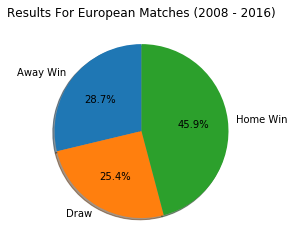

In [151]:
match_results = df_match_combined.groupby('match_result').size()

plt = match_results.plot(kind='pie', title='Results For European Matches (2008 - 2016)', labels=['Away Win', 'Draw', 'Home Win'], autopct='%1.1f%%', shadow=True, startangle=90)

plet = plt.set_ylabel('')

### *Across all European leagues - the home team wins the match 45% of the time!*

Now, let's explore the breakdown of match results by league.

In [152]:
# Create data set of individual league home win, away win and draw percentages

leagues = df_match_combined.league_name.unique()

data = []

for league in leagues:
    home_wins = df_match_combined.loc[(df_match_combined['league_name'] == league) & (df_match_combined['match_result'] == 'home')].shape[0]
    away_wins = df_match_combined.loc[(df_match_combined['league_name'] == league) & (df_match_combined['match_result'] == 'away')].shape[0]
    draws = df_match_combined.loc[(df_match_combined['league_name'] == league) & (df_match_combined['match_result'] == 'draw')].shape[0]
    
    total_league_games = home_wins + away_wins + draws
    
    home_win_percentage = (home_wins / total_league_games) * 100
    away_win_percentage = (away_wins / total_league_games) * 100
    draw_percentage = (draws / total_league_games) * 100
    
    data.append([league, home_win_percentage, away_win_percentage, draw_percentage])

### Match Result: Home Team Wins

In [153]:
# Create dataframe with percentages by league with specified columns

df = pd.DataFrame(data=data, columns=["league", "Home Win Rate", "Away Win Rate", 'Draw Rate'])

In [154]:
# Prepare dataframe to be displayed - sort values by Home Win Rate

df_win = df.sort_values(by=['Home Win Rate'], ascending=False)

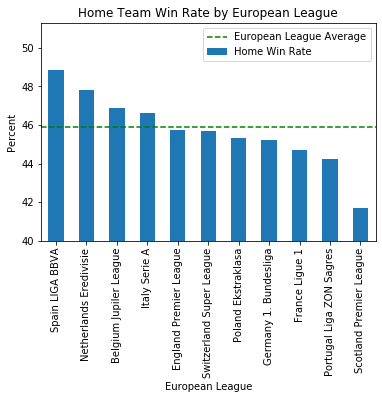

In [155]:
# Plot df_win and display European League average home win percentage for comparison

plt = df_win.plot.bar(x='league', y='Home Win Rate')

plt.set_xticklabels(df_win.league, rotation=90)
plt.set_title('Home Team Win Rate by European League')
plt.set_xlabel('European League')
plt.set_ylabel('Percent');
plt.set_ylim(bottom=40)
plt.axhline(y=overall_home_win_percentage, color='g', linestyle='--', label="European League Average")
plt.legend()

### *Only 4 out of the 11 leagues have a home team win rate greater than the 45% average across all leagues*
___

### Match Result: Away Team Wins

In [156]:
# Prepare dataframe to be displayed - sort values by Away Win Rate

df_away = df.sort_values(by=['Away Win Rate'], ascending=False)

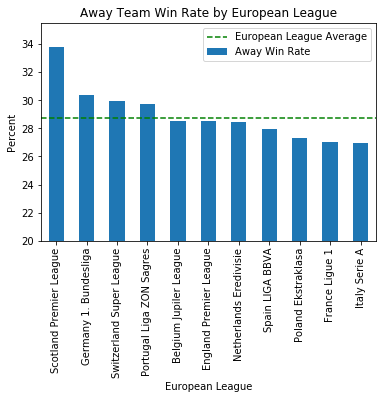

In [157]:
# Plot df_away and display European League average home win percentage for comparison

plt = df_away.plot.bar(x='league', y='Away Win Rate')

plt.set_xticklabels(df_away.league, rotation=90)
plt.set_title('Away Team Win Rate by European League')
plt.set_xlabel('European League')
plt.set_ylabel('Percent');
plt.set_ylim(bottom=20)
plt.axhline(y=overall_away_win_percentage, color='g', linestyle='--', label="European League Average")
plt.legend()

### *If you're looking to see the away team win, I recommend attending a Scotland Premier League match!*
___

### Match Result: Draw

In [158]:
# Prepare dataframe to be displayed - sort values by Draw Rate

df_draw = df.sort_values(by=['Draw Rate'], ascending=False)

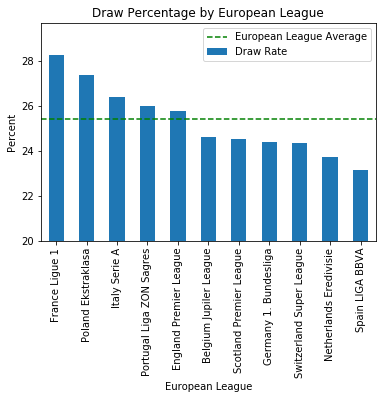

In [159]:
# Plot df_draw and display European League average draw percentage for comparison

plt = df_draw.plot.bar(x='league', y='Draw Rate')

plt.set_xticklabels(df_draw.league, rotation=90)
plt.set_title('Draw Percentage by European League')
plt.set_xlabel('European League')
plt.set_ylabel('Percent');
plt.set_ylim(bottom=20)
plt.axhline(y=overall_draw_percentage, color='g', linestyle='--', label="European League Average")
plt.legend()

### *Matches from the Spain LIGA BBVA league are least likely to end in a draw*
____

With a better understanding of match result, let's see if there is any correlation to goals scored per league.

### Initial Question: How do goals scored by the home & away teams per match compare across the European leagues?

In [160]:
# Refresh original df_match_combined info to see columns

df_match_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 12 columns):
match_api_id        25979 non-null int64
date                25979 non-null object
league_id           25979 non-null int64
stage               25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
home_team_name      25979 non-null object
away_team_name      25979 non-null object
league_name         25979 non-null object
match_result        25979 non-null object
dtypes: int64(7), object(5)
memory usage: 2.6+ MB


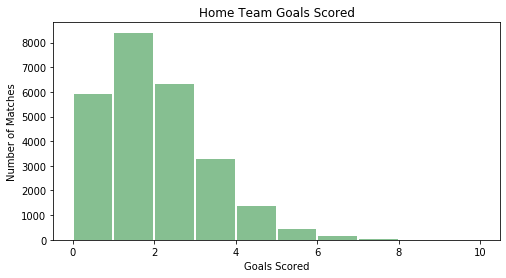

In [161]:
axarr = df_match_combined.hist(column='home_team_goal', grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.95)

for ax in axarr.flatten():
    ax.set_title("Home Team Goals Scored")
    ax.set_xlabel("Goals Scored")
    ax.set_ylabel("Number of Matches")

In [162]:
# Calculate average number of goals scored by home teams across all European matches

overall_average_home_goals_per_game = np.average(df_match_combined.home_team_goal)

print(overall_average_home_goals_per_game)

1.5445937103044767


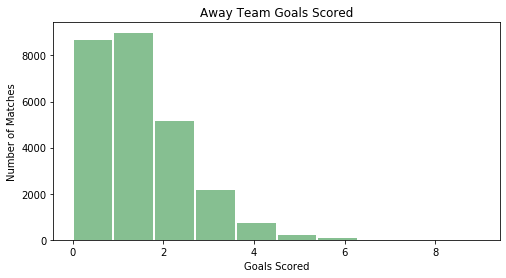

In [163]:
axarr = df_match_combined.hist(column='away_team_goal', grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.95)

for ax in axarr.flatten():
    ax.set_title("Away Team Goals Scored")
    ax.set_xlabel("Goals Scored")
    ax.set_ylabel("Number of Matches")

In [164]:
# Calculate average number of goals scored by away teams across all European matches

overall_average_away_goals_per_game = np.average(df_match_combined.away_team_goal)

print(overall_average_away_goals_per_game)

1.1609376804341969


In [165]:
# Calculate average number of goals scored per game across all European matches

total_goals = np.sum(df_match_combined.home_team_goal) + np.sum(df_match_combined.away_team_goal)

overall_average_goals_per_game = total_goals / total_games_played

print(overall_average_goals_per_game)

2.7055313907386735


##### *As expected -  since the home team wins more often than the away team, the home team averages more goals per game than the away team*
___

In [166]:
# Create data set of average goals scored for home and away teams by European league

data = []

for league in leagues:
    league_rows = df_match_combined.loc[(df_match_combined['league_name'] == league)]
    
    average_home_goals_per_game = np.average(league_rows.home_team_goal)
    average_away_goals_per_game = np.average(league_rows.away_team_goal)
    
    home_goals = league_rows.home_team_goal.sum()
    away_goals = league_rows.away_team_goal.sum()
    total_games = league_rows.shape[0]
    average_goals_per_game = (home_goals + away_goals) / total_games
    
    data.append([league, average_home_goals_per_game, average_away_goals_per_game, average_goals_per_game])

In [167]:
# Create dataframe with average goals per match by league with specified columns

df = pd.DataFrame(data=data, columns=["league", "Average Home Goals", "Average Away Goals", "Average Goals"])

### Home Goals Per Game Comparison

In [168]:
# Prepare dataframe to be displayed - sort values by Average Home Goals

df_home_goals = df.sort_values(by=['Average Home Goals'], ascending=False)

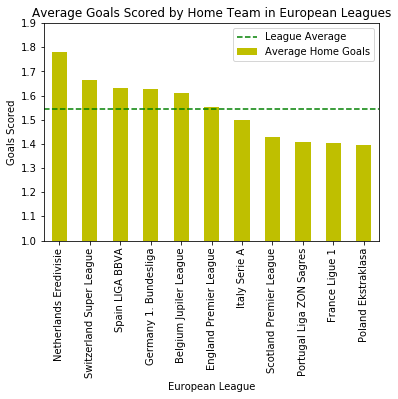

In [169]:
# Plot df_home_goals and display European League average goals per match for comparison

plt = df_home_goals.plot.bar(x='league', y='Average Home Goals', color='y')

plt.set_xticklabels(df_home_goals.league, rotation=90)
plt.set_title('Average Goals Scored by Home Team in European Leagues')
plt.set_xlabel('European League')
plt.set_ylabel('Goals Scored');
plt.set_ylim(bottom=1, top=1.9)
plt.axhline(y=overall_average_home_goals_per_game, color='g', linestyle='--', label="League Average")
plt.legend()

### Away Goals Per Game Comparison

In [170]:
# Prepare dataframe to be displayed - sort values by Average Away Goals

df_away_goals = df.sort_values(by=['Average Away Goals'], ascending=False)

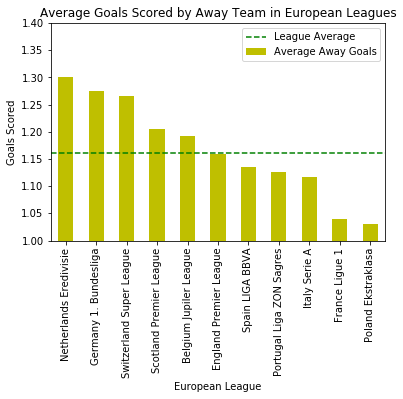

In [171]:
# Plot df_away_goals and display European League average goals per match for comparison

plt = df_away_goals.plot.bar(x='league', y='Average Away Goals', color='y')

plt.set_xticklabels(df_away_goals.league, rotation=90)
plt.set_title('Average Goals Scored by Away Team in European Leagues')
plt.set_xlabel('European League')
plt.set_ylabel('Goals Scored');
plt.set_ylim(bottom=1, top=1.4)
plt.axhline(y=overall_average_away_goals_per_game, color='g', linestyle='--', label="League Average")
plt.legend()

### Total Goals Per Game Comparison

In [172]:
# Prepare dataframe to be displayed - sort values by Average Goals

df_avg_goals = df.sort_values(by=['Average Goals'], ascending=False)

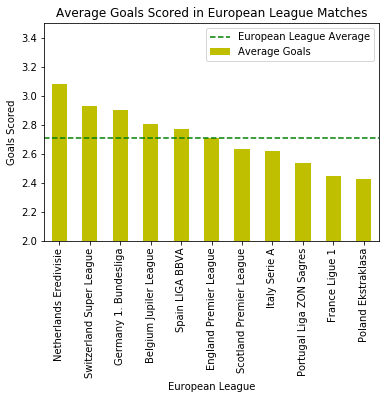

In [173]:
# Plot df_avg_goals and display European League average goals per match for comparison

plt = df_avg_goals.plot.bar(x='league', y='Average Goals', color='y')

plt.set_xticklabels(df_avg_goals.league, rotation=90)
plt.set_title('Average Goals Scored in European League Matches')
plt.set_xlabel('European League')
plt.set_ylabel('Goals Scored');
plt.set_ylim(bottom=2, top=3.5)
plt.axhline(y=overall_average_goals_per_game, color='g', linestyle='--', label="European League Average")
plt.legend()

_____

<a id='conclusions'></a>
## Conclusions

##### Home Teams Win & Score More Goals

My initial hypothesis that the home team wins more often than the away team and averages more goals per game, proved to be correct. Through this analysis, I can confidently state that each European league has a greater percentage of home team wins than away team wins. In addition, the home team averages more goals per game in each league than the away team.


###### But... the most likely outcome is that the home team does not win...

One aspect of this analysis that I found interesting was the home win rate compared to any other match result (away win or draw). In this case, no European league home win rate exceeds 50% - meaning that a home win is not necessarily the most likely outcome of a match. In fact, it would appear as though it is more likely for an away team to win or the match to end in a draw than for the home team to win.


###### There's always more to do!

This exploration should not be relied on to make conclusions about the probability of a match resulting in a win, loss or draw. I chose to explore match results and goals scored across *all* European League matches. The focus of this analysis could be narrowed by analyzing results of a single team. Drilling down to the team level would enable additional conclusion about how likely that a team's home match - for example - would end in a win.

There are many questions yet to be answered through this analysis - here are a few that come to mind: 

1. Does opponent difficulty affect the result's of a team's home match win/loss/draw record?

2. How are team records affected when their roster is changed year over year?

3. Are matches ever played at 'neutral' locations?

These questions would be a good starting place if exploring this dataset in the future.

___

<a id='resources'></a>

## Resources

*European Soccer Data: https://www.kaggle.com/hugomathien/soccer* 